# Dataframe creation

Import statements

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error

Read in dataframe

In [6]:
visitation = pd.read_csv("2025 Allianz Datathon Dataset(Visitation Data).csv")
visitation = visitation.iloc[:165,:]
climate = pd.read_csv("2025 Allianz Datathon Dataset(Climate Data).csv")

Check for nan values

In [8]:
print(visitation.isnull().sum())
print(climate.isnull().sum())

Year              0
Week              0
Mt. Baw Baw       0
Mt. Stirling      0
Mt. Hotham        0
Falls Creek       0
Mt. Buller        0
Selwyn            0
Thredbo           0
Perisher          0
Charlotte Pass    0
dtype: int64
Bureau of Meteorology station number       0
Year                                       0
Month                                      0
Day                                        0
Maximum temperature (Degree C)          1538
Minimum temperature (Degree C)          1533
Rainfall amount (millimetres)           1956
dtype: int64


Check for nan values by year

In [11]:
for year in range(2010, 2026):
    climate_specific_year = climate[climate["Year"] == year]
    print(year, climate_specific_year["Maximum temperature (Degree C)"].isnull().sum())


2010 189
2011 61
2012 44
2013 5
2014 9
2015 90
2016 24
2017 30
2018 50
2019 168
2020 192
2021 126
2022 147
2023 207
2024 159
2025 37


Impute missing values using interpolation

In [16]:
#Use cubic interpolation to impute temperature
climate["Maximum temperature (Degree C)"] = climate["Maximum temperature (Degree C)"].interpolate(method='cubic')
climate["Minimum temperature (Degree C)"] = climate["Minimum temperature (Degree C)"].interpolate(method='cubic')
#Use linear interpolation to impute rainfall
climate["Rainfall amount (millimetres)"] = climate["Rainfall amount (millimetres)"].interpolate(method='linear')

#Optional: check missing values for each year
for year in range(2010, 2026):
    climate_specific_year = climate[climate["Year"] == year]
    print(year, climate_specific_year.isnull().sum())


2010 Bureau of Meteorology station number      0
Year                                      0
Month                                     0
Day                                       0
Maximum temperature (Degree C)          144
Minimum temperature (Degree C)          145
Rainfall amount (millimetres)           145
dtype: int64
2011 Bureau of Meteorology station number    0
Year                                    0
Month                                   0
Day                                     0
Maximum temperature (Degree C)          0
Minimum temperature (Degree C)          0
Rainfall amount (millimetres)           0
dtype: int64
2012 Bureau of Meteorology station number    0
Year                                    0
Month                                   0
Day                                     0
Maximum temperature (Degree C)          0
Minimum temperature (Degree C)          0
Rainfall amount (millimetres)           0
dtype: int64
2013 Bureau of Meteorology station number    0
Yea

Create dataframes for each ski resort

In [19]:
#This function takes a row in the dataframe as input and returns the week of the skiing season it corresponds to. It returns NaN if the row falls outside of the ski season.
def assign_ski_week(row):
    year = row.date.year
    #Week 1 start
    start = pd.Timestamp(year, 6, 9) 
    #Week 15 end
    end   = pd.Timestamp(year, 9, 21)  

    if not (start <= row.date <= end):
        return np.nan
    
    #Days since 9 June
    days_offset = (row.date - start).days
    #Weeks since 9 June
    week = days_offset // 7 + 1
    return week

def createDataframe(resort_name, station_number):
    #Create visitation dataframe for just the specific skiing resort
    specific_visitation = visitation[["Year", "Week", resort_name]].rename(
        columns={resort_name: "visitation"}
    )
    
    #Create climate dataframe for just the specific station number
    specific_climate = climate[climate["Bureau of Meteorology station number"] == station_number].copy()
    
    #Build datetime column
    specific_climate["date"] = pd.to_datetime(specific_climate[["Year", "Month", "Day"]])
    
    #Apply the assign_ski_week function to each row in the climate dataframe
    specific_climate["Week"] = specific_climate.apply(assign_ski_week, axis=1)
    specific_climate["Year"] = specific_climate["date"].dt.year
    
    #Drop rows outside ski season
    specific_climate = specific_climate.dropna(subset=["Week"])
    
    #Calculate mean temperature statistics and the sum of of all snow
    weekly_climate = specific_climate.groupby(["Year", "Week"]).agg({
        "Maximum temperature (Degree C)": "mean",
        "Minimum temperature (Degree C)": "mean",
        "Rainfall amount (millimetres)": "sum"
    }).reset_index()
    
    #Rename columns for clarity
    weekly_climate = weekly_climate.rename(columns={
        "Maximum temperature (Degree C)": "maxtemp",
        "Minimum temperature (Degree C)": "mintemp",
        "Rainfall amount (millimetres)": "snow"
    })
    
    #Merge the visitation and climate dataframes
    specific_df = pd.merge(
        specific_visitation,
        weekly_climate,
        on=["Year", "Week"],
        how="left"
    )
    
    return specific_df

bawbaw = createDataframe("Mt. Baw Baw", 85291)
stirling = createDataframe("Mt. Stirling", 83024) #Mt Stirling uses Mt. Buller's station number
hotham = createDataframe("Mt. Hotham", 83085)
falls = createDataframe("Falls Creek", 83084)
buller = createDataframe("Mt. Buller", 83024)
selwyn = createDataframe("Selwyn", 72161)
thredbo = createDataframe("Thredbo", 71032)
perisher = createDataframe("Perisher", 71075)
charlotte = createDataframe("Charlotte Pass", 71032) #Charlotte Pass could use either 71032 or 71075, but 71032 has slightly less NaN values in its climate data

Checking nan values for the two closest weather stations to Charlotte Pass ski resort.

In [21]:
climate[climate["Bureau of Meteorology station number"] == 71032].isnull().sum()


Bureau of Meteorology station number    0
Year                                    0
Month                                   0
Day                                     0
Maximum temperature (Degree C)          0
Minimum temperature (Degree C)          0
Rainfall amount (millimetres)           0
dtype: int64

In [22]:
climate[climate["Bureau of Meteorology station number"] == 71075].isnull().sum()

Bureau of Meteorology station number      0
Year                                      0
Month                                     0
Day                                       0
Maximum temperature (Degree C)          144
Minimum temperature (Degree C)          145
Rainfall amount (millimetres)           145
dtype: int64

View the dataframes

In [27]:
bawbaw

,Year,Week,visitation,maxtemp,mintemp,snow
0,2014.0,1.0,555.0,4.957143,1.100000,24.4
1,2014.0,2.0,804.0,5.485714,0.814286,21.0
2,2014.0,3.0,993.0,1.042857,-1.814286,83.3
3,2014.0,4.0,2976.0,2.528571,-0.957143,82.0
4,2014.0,5.0,11112.0,0.685714,-2.257143,82.6
...,...,...,...,...,...,...
160,2024.0,11.0,5977.0,6.157143,1.296722,26.2
161,2024.0,12.0,3597.0,5.428571,0.928571,23.6
162,2024.0,13.0,1500.0,7.142857,-0.100000,50.6
163,2024.0,14.0,0.0,5.628571,0.261872,45.8


In [29]:
stirling

,Year,Week,visitation,maxtemp,mintemp,snow
0,2014.0,1.0,60.0,4.271429,-0.014286,19.0
1,2014.0,2.0,42.0,5.257143,-0.342857,47.6
2,2014.0,3.0,30.0,0.385714,-2.514286,133.6
3,2014.0,4.0,165.0,0.957143,-1.857143,80.0
4,2014.0,5.0,645.0,-0.285714,-3.400000,71.4
...,...,...,...,...,...,...
160,2024.0,11.0,1416.0,4.885714,0.828571,44.2
161,2024.0,12.0,701.0,4.257143,0.157143,43.6
162,2024.0,13.0,213.0,6.100000,-0.671429,44.4
163,2024.0,14.0,0.0,5.728571,-0.571429,26.4


In [31]:
hotham

,Year,Week,visitation,maxtemp,mintemp,snow
0,2014.0,1.0,3483.0,3.457143,-1.142857,42.0
1,2014.0,2.0,1253.0,3.000000,-1.257143,13.0
2,2014.0,3.0,2992.0,-0.900000,-3.285714,23.0
3,2014.0,4.0,9680.0,-0.985714,-3.471429,0.6
4,2014.0,5.0,29628.0,-1.842857,-4.000000,3.2
...,...,...,...,...,...,...
160,2024.0,11.0,24260.0,3.471429,-0.057143,51.0
161,2024.0,12.0,19289.0,2.871429,-0.614286,103.0
162,2024.0,13.0,14487.0,4.714286,-1.357143,36.2
163,2024.0,14.0,2700.0,4.628571,-1.000000,29.6


In [33]:
falls

,Year,Week,visitation,maxtemp,mintemp,snow
0,2014.0,1.0,2790.0,4.600000,-0.300000,23.8
1,2014.0,2.0,1425.0,4.414286,-0.285714,7.6
2,2014.0,3.0,2101.0,0.100000,-2.828571,69.6
3,2014.0,4.0,9544.0,1.385714,-2.685714,24.2
4,2014.0,5.0,26211.0,-0.728571,-3.757143,13.6
...,...,...,...,...,...,...
160,2024.0,11.0,38541.0,3.874503,0.433813,49.2
161,2024.0,12.0,42101.0,3.214286,-0.157143,75.0
162,2024.0,13.0,25252.0,5.771429,-0.514286,39.6
163,2024.0,14.0,17137.0,5.900000,-0.585714,22.2


In [35]:
buller

,Year,Week,visitation,maxtemp,mintemp,snow
0,2014.0,1.0,8296.0,4.271429,-0.014286,19.0
1,2014.0,2.0,1987.0,5.257143,-0.342857,47.6
2,2014.0,3.0,2413.0,0.385714,-2.514286,133.6
3,2014.0,4.0,18831.0,0.957143,-1.857143,80.0
4,2014.0,5.0,49217.0,-0.285714,-3.400000,71.4
...,...,...,...,...,...,...
160,2024.0,11.0,43387.0,4.885714,0.828571,44.2
161,2024.0,12.0,36668.0,4.257143,0.157143,43.6
162,2024.0,13.0,15415.0,6.100000,-0.671429,44.4
163,2024.0,14.0,0.0,5.728571,-0.571429,26.4


In [37]:
selwyn

,Year,Week,visitation,maxtemp,mintemp,snow
0,2014.0,1.0,1041.0,6.828571,1.571429,29.2
1,2014.0,2.0,383.0,6.714286,1.528571,14.4
2,2014.0,3.0,597.0,1.671429,-0.857143,109.0
3,2014.0,4.0,2877.0,3.142857,-0.757143,60.2
4,2014.0,5.0,8588.0,1.271429,-2.257143,44.2
...,...,...,...,...,...,...
160,2024.0,11.0,6859.0,8.600000,2.628571,22.4
161,2024.0,12.0,5969.0,7.242857,1.928571,27.2
162,2024.0,13.0,3351.0,9.301800,2.085714,20.1
163,2024.0,14.0,1177.0,8.728571,2.142857,24.2


In [39]:
thredbo

,Year,Week,visitation,maxtemp,mintemp,snow
0,2014.0,1.0,5535.0,4.714286,-2.000000,40.6
1,2014.0,2.0,2090.0,2.657143,-1.685714,8.0
2,2014.0,3.0,3216.0,-1.028571,-4.114286,4.2
3,2014.0,4.0,15497.0,-1.314286,-4.357143,0.5
4,2014.0,5.0,46546.0,-1.685714,-5.185714,3.0
...,...,...,...,...,...,...
160,2024.0,11.0,37608.0,3.500000,-0.700000,29.8
161,2024.0,12.0,33208.0,2.500000,-1.171429,69.4
162,2024.0,13.0,18120.0,4.614286,-0.700000,23.6
163,2024.0,14.0,6270.0,5.857143,-1.242857,11.4


In [41]:
perisher

,Year,Week,visitation,maxtemp,mintemp,snow
0,2014.0,1.0,7370.0,6.328571,-1.585714,62.0
1,2014.0,2.0,2751.0,5.257143,-1.857143,13.8
2,2014.0,3.0,4255.0,0.885714,-2.457143,220.6
3,2014.0,4.0,20265.0,2.942857,-2.457143,53.8
4,2014.0,5.0,61339.0,1.185714,-3.757143,39.0
...,...,...,...,...,...,...
160,2024.0,11.0,49136.0,6.300000,0.085714,29.4
161,2024.0,12.0,43382.0,4.585714,0.671429,99.2
162,2024.0,13.0,23908.0,7.985714,0.671429,41.0
163,2024.0,14.0,8244.0,8.971429,-0.728571,5.4


In [43]:
charlotte

,Year,Week,visitation,maxtemp,mintemp,snow
0,2014.0,1.0,408.0,4.714286,-2.000000,40.6
1,2014.0,2.0,151.0,2.657143,-1.685714,8.0
2,2014.0,3.0,230.0,-1.028571,-4.114286,4.2
3,2014.0,4.0,1134.0,-1.314286,-4.357143,0.5
4,2014.0,5.0,3403.0,-1.685714,-5.185714,3.0
...,...,...,...,...,...,...
160,2024.0,11.0,2667.0,3.500000,-0.700000,29.8
161,2024.0,12.0,2392.0,2.500000,-1.171429,69.4
162,2024.0,13.0,1323.0,4.614286,-0.700000,23.6
163,2024.0,14.0,454.0,5.857143,-1.242857,11.4


# Metric for deciding which resort to ski at

In [46]:
#Define a function to score a 1 if x is within target range, or less than 1 if a little outside the range
def range_score(x, low, high, hard_min=None, hard_max=None):
    if hard_min is None: hard_min = low
    if hard_max is None: hard_max = high
    
    if x < hard_min or x > hard_max:
        return 0.0
    elif low <= x <= high:
        return 1.0
    elif x < low:
        return (x - hard_min) / (low - hard_min)
    else:  # x > high
        return (hard_max - x) / (hard_max - high)

#Define a function to compute the weekly scores for a specific resort and calculate the mean, median and number of weeks above a score of 0.7
def compute_scores(df, wV=0.3, wT=0.3, wS=0.4):
    scores = []
    for _, row in df.iterrows():
        v = range_score(row['visitation'], df['visitation'].mean()*0.7, df['visitation'].mean()*1.3, hard_min=df['visitation'].mean()*0.2, hard_max=df['visitation'].mean()*3)
        t_max = range_score(row['maxtemp'], -1, 3, hard_min=-1, hard_max=5)
        t_min = range_score(row['mintemp'], -3, -1, hard_min=-5, hard_max=1)
        t = (t_max + t_min) / 2
        s = range_score(row['snow'], 35, 105, hard_min=10, hard_max=150)
        
        composite = wV*v + wT*t + wS*s
        scores.append((v, t, s, composite))
        
    df[['V_score', 'T_score', 'S_score', 'Composite']] = scores
        
    summary = {
        "mean_score": df['Composite'].mean(),
        "median_score": df['Composite'].median(),
        "weeks_above_0.7": (df['Composite'] > 0.7).mean()
    }
    
    return summary

print(compute_scores(bawbaw))
print(compute_scores(stirling))
print(compute_scores(hotham))
print(compute_scores(falls))
print(compute_scores(buller))
print(compute_scores(selwyn))
print(compute_scores(thredbo))
print(compute_scores(perisher))
print(compute_scores(charlotte))




{'mean_score': 0.6508016582572073, 'median_score': 0.6663656072506462, 'weeks_above_0.7': 0.43636363636363634}
{'mean_score': 0.5961047462292095, 'median_score': 0.6098639187648309, 'weeks_above_0.7': 0.34545454545454546}
{'mean_score': 0.5298351483373365, 'median_score': 0.5009337514033099, 'weeks_above_0.7': 0.24242424242424243}
{'mean_score': 0.6253973483549292, 'median_score': 0.6181225324937576, 'weeks_above_0.7': 0.4}
{'mean_score': 0.6599032857706475, 'median_score': 0.6821699567340467, 'weeks_above_0.7': 0.45454545454545453}
{'mean_score': 0.5262124862806978, 'median_score': 0.5011937674597823, 'weeks_above_0.7': 0.28484848484848485}
{'mean_score': 0.5176334513906045, 'median_score': 0.5108930385799124, 'weeks_above_0.7': 0.19393939393939394}
{'mean_score': 0.608288597972189, 'median_score': 0.6390807855186641, 'weeks_above_0.7': 0.4303030303030303}
{'mean_score': 0.5174977605184795, 'median_score': 0.5127337087631033, 'weeks_above_0.7': 0.19393939393939394}


# Using Light GBM to model weather for 2026

In [48]:
climate = climate[climate["Bureau of Meteorology station number"] == 83024]
climate

,Bureau of Meteorology station number,Year,Month,Day,Maximum temperature (Degree C),Minimum temperature (Degree C),Rainfall amount (millimetres)
11373,83024,2010,1,1,16.3,10.3,22.2
11374,83024,2010,1,2,13.0,10.4,40.6
11375,83024,2010,1,3,13.2,1.8,0.6
11376,83024,2010,1,4,16.7,7.8,0.0
11377,83024,2010,1,5,19.2,9.8,0.0
...,...,...,...,...,...,...,...
17056,83024,2025,7,24,-0.9,-4.1,1.8
17057,83024,2025,7,25,0.0,-4.5,0.4
17058,83024,2025,7,26,0.7,-2.9,3.4
17059,83024,2025,7,27,0.0,-0.8,10.0


Add useful columns regarding the date

In [51]:
climate['Date'] = pd.to_datetime(climate[['Year', 'Month', 'Day']])
climate['DayOfYear'] = climate['Date'].dt.dayofyear
climate.set_index('Date', inplace=True)

Drop rows that still have missing values after interpolation

In [54]:
climate.dropna(inplace=True)

Now the dataframe has no missing values, and the data types are consistent too

In [57]:
#Check for any remaining missing values
print(climate.isnull().sum())

#Check the data types
print(climate.dtypes)


Bureau of Meteorology station number    0
Year                                    0
Month                                   0
Day                                     0
Maximum temperature (Degree C)          0
Minimum temperature (Degree C)          0
Rainfall amount (millimetres)           0
DayOfYear                               0
dtype: int64
Bureau of Meteorology station number      int64
Year                                      int64
Month                                     int64
Day                                       int64
Maximum temperature (Degree C)          float64
Minimum temperature (Degree C)          float64
Rainfall amount (millimetres)           float64
DayOfYear                                 int32
dtype: object


Create more new columns representing various statistics. The graph immediately below is feature importance when is_winter was included.

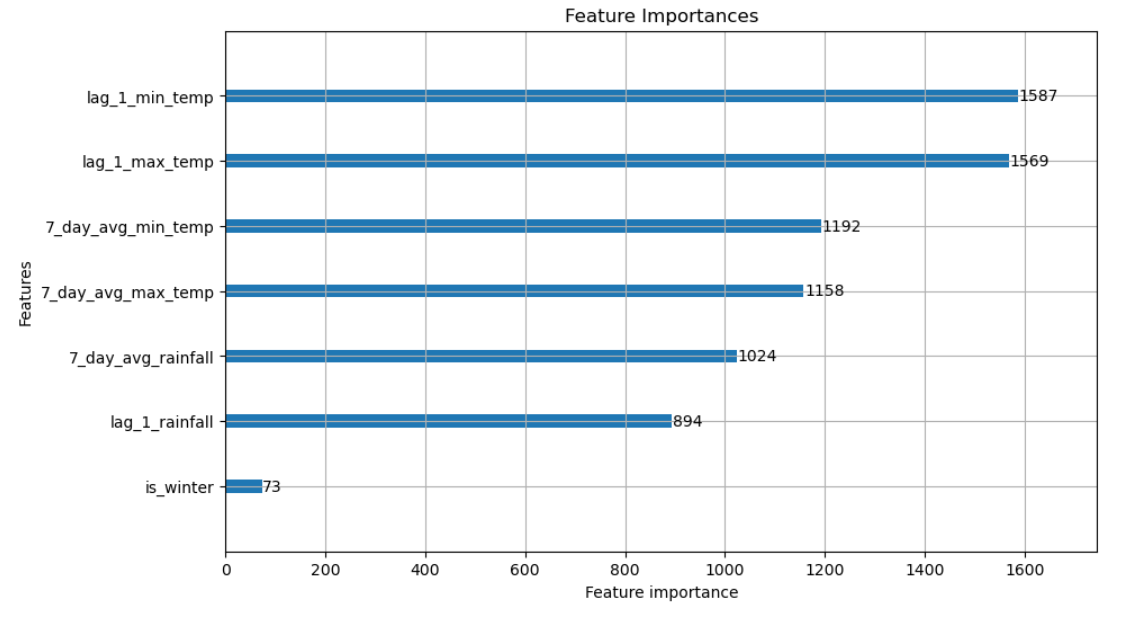

In [61]:
#7-day rolling average for temperatures and rainfall
climate['7_day_avg_max_temp'] = climate['Maximum temperature (Degree C)'].shift(1).rolling(window=7).mean()
climate['7_day_avg_min_temp'] = climate['Minimum temperature (Degree C)'].shift(1).rolling(window=7).mean()
climate['7_day_avg_rainfall'] = climate['Rainfall amount (millimetres)'].shift(1).rolling(window=7).mean()

#Rainfall and temperature data the day before
climate['lag_1_max_temp'] = climate['Maximum temperature (Degree C)'].shift(1)
climate['lag_1_min_temp'] = climate['Minimum temperature (Degree C)'].shift(1)
climate['lag_1_rainfall'] = climate['Rainfall amount (millimetres)'].shift(1)

#Rainfall and temperature data 2 days before
climate['lag_2_max_temp'] = climate['Maximum temperature (Degree C)'].shift(2)
climate['lag_2_min_temp'] = climate['Minimum temperature (Degree C)'].shift(2)
climate['lag_2_rainfall'] = climate['Rainfall amount (millimetres)'].shift(2)

# Rainfall and temperature data 3 days before
climate['lag_3_max_temp'] = climate['Maximum temperature (Degree C)'].shift(3)
climate['lag_3_min_temp'] = climate['Minimum temperature (Degree C)'].shift(3)
climate['lag_3_rainfall'] = climate['Rainfall amount (millimetres)'].shift(3)

#is_winter was removed

Once again drop nan rows which have been created due to some new columns like rolling averages

In [64]:
climate.dropna(inplace=True)

Format X and Y train and test data

In [67]:
#Filter the data for training and testing based on year
train_data = climate[climate.index.year <= 2022] 
test_data = climate[climate.index.year >= 2023]  

#Define features (X) and target (y) for both training and testing sets
X_train = train_data[['7_day_avg_max_temp', '7_day_avg_min_temp', '7_day_avg_rainfall', 'lag_1_max_temp', 'lag_1_min_temp', 'lag_1_rainfall', 
                      'lag_2_max_temp', 'lag_2_min_temp', 'lag_2_rainfall', 'lag_3_max_temp', 'lag_3_min_temp', 'lag_3_rainfall']]
X_test = test_data[['7_day_avg_max_temp', '7_day_avg_min_temp', '7_day_avg_rainfall', 'lag_1_max_temp', 'lag_1_min_temp', 'lag_1_rainfall',
                   'lag_2_max_temp', 'lag_2_min_temp', 'lag_2_rainfall', 'lag_3_max_temp', 'lag_3_min_temp', 'lag_3_rainfall']]

#Apply log transformation only to rainfall
y_train_rainfall = np.log1p(train_data['Rainfall amount (millimetres)'])
y_test_rainfall = np.log1p(test_data['Rainfall amount (millimetres)'])

#Temperature targets (no transformation)
y_train_max_temp = train_data['Maximum temperature (Degree C)']
y_train_min_temp = train_data['Minimum temperature (Degree C)']

y_test_max_temp = test_data['Maximum temperature (Degree C)']
y_test_min_temp = test_data['Minimum temperature (Degree C)']

Train model

In [70]:
#Create LightGBM dataset for each target separately
train_data_rainfall = lgb.Dataset(X_train, label=y_train_rainfall)
test_data_rainfall = lgb.Dataset(X_test, label=y_test_rainfall)

train_data_max_temp = lgb.Dataset(X_train, label=y_train_max_temp)
test_data_max_temp = lgb.Dataset(X_test, label=y_test_max_temp)

train_data_min_temp = lgb.Dataset(X_train, label=y_train_min_temp)
test_data_min_temp = lgb.Dataset(X_test, label=y_test_min_temp)

#Set parameters for LightGBM (same for all three targets)
params = {
    'objective': 'regression',
    'metric': 'mae', 
    'boosting_type': 'gbdt',
    'num_leaves': 50,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
}

# Early stopping callback
early_stopping = lgb.callback.early_stopping(stopping_rounds=50, verbose=True)

#Train the model with early stopping for rainfall (log-transformed)
model_rainfall = lgb.train(
    params,
    train_data_rainfall,
    valid_sets=[test_data_rainfall],
    num_boost_round=1000,
    callbacks=[early_stopping]
)

#Train the model with early stopping for max temperature
model_max_temp = lgb.train(
    params,
    train_data_max_temp,
    valid_sets=[test_data_max_temp],
    num_boost_round=1000,
    callbacks=[early_stopping]
)

#Train the model with early stopping for min temperature
model_min_temp = lgb.train(
    params,
    train_data_min_temp,
    valid_sets=[test_data_min_temp],
    num_boost_round=1000,
    callbacks=[early_stopping]
)

#Make predictions
y_pred_rainfall = model_rainfall.predict(X_test, num_iteration=model_rainfall.best_iteration)
y_pred_max_temp = model_max_temp.predict(X_test, num_iteration=model_max_temp.best_iteration)
y_pred_min_temp = model_min_temp.predict(X_test, num_iteration=model_min_temp.best_iteration)

#Inverse log transformation only on rainfall predictions
rainfall_pred = np.expm1(y_pred_rainfall) 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000963 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3027
[LightGBM] [Info] Number of data points in the train set: 4741, number of used features: 12
[LightGBM] [Info] Start training from score 0.842520
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[96]	valid_0's l1: 0.699378
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3027
[LightGBM] [Info] Number of data points in the train set: 4741, number of used features: 12
[LightGBM] [Info] Start training from score 9.815367
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[94]	valid_0's l1: 2.23664
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead 

Evaluate model

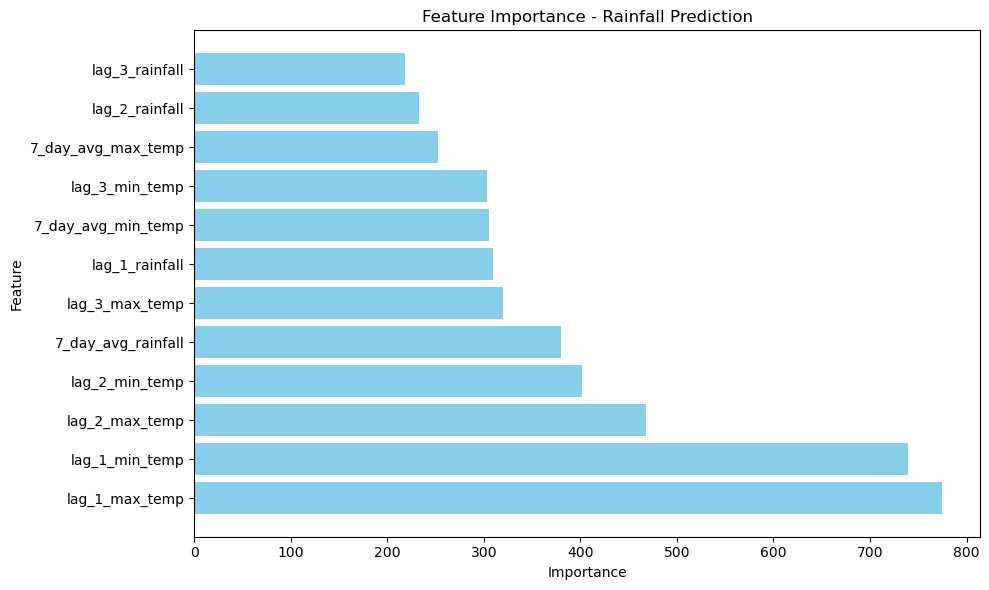

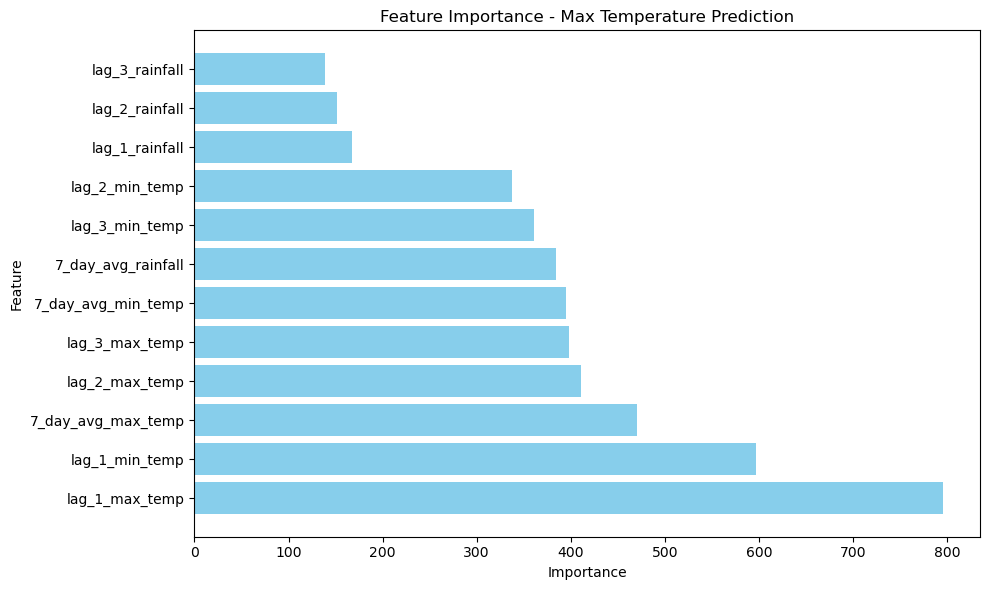

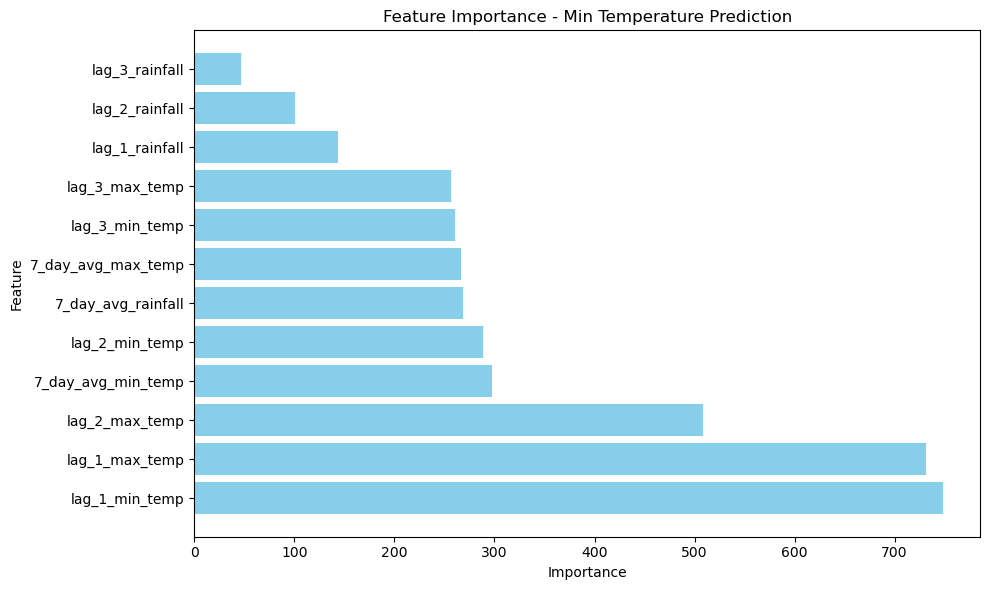

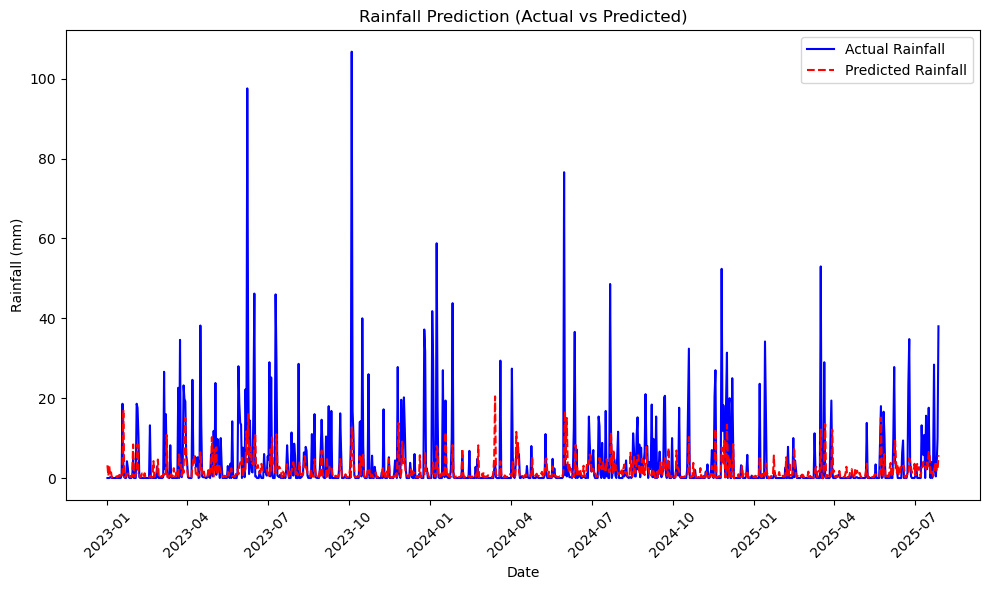

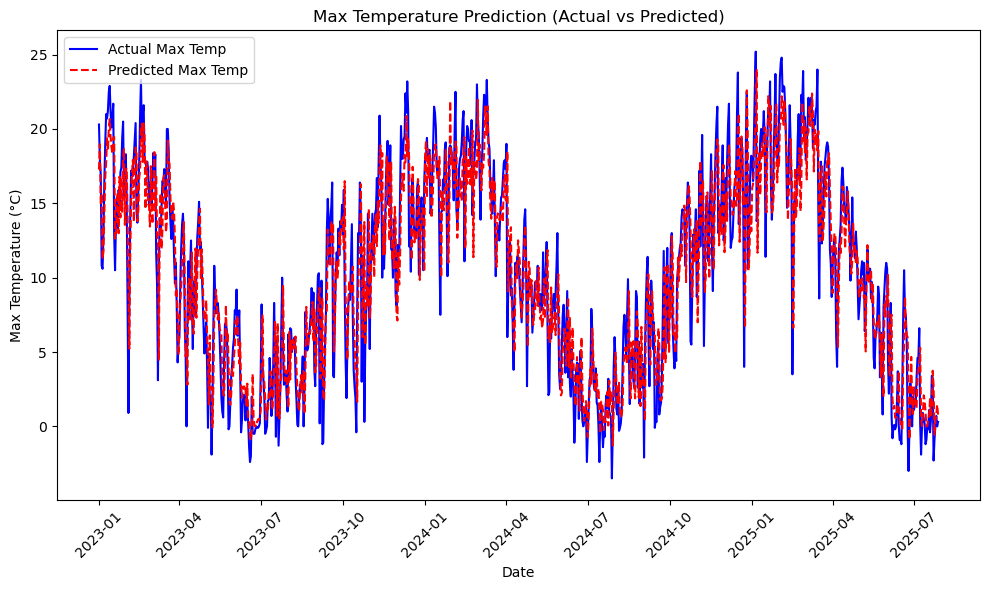

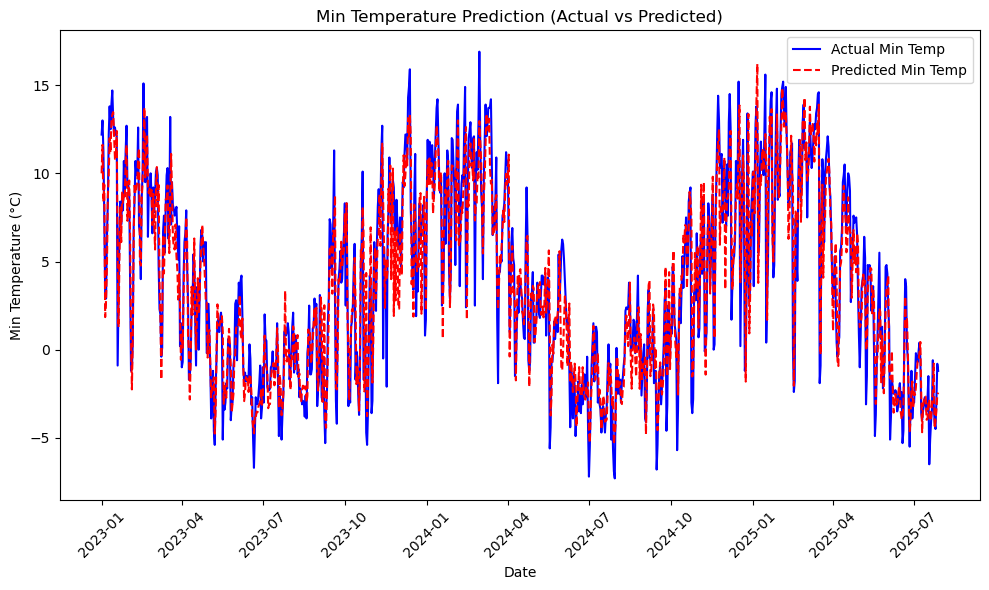

In [72]:
#Feature Importance Plot for all three models
def plot_feature_importance(model, feature_names, title):
    importance = model.feature_importance()
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
    
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
    plt.title(f'Feature Importance - {title}')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

#Plot feature importance for Rainfall model
plot_feature_importance(model_rainfall, X_train.columns, 'Rainfall Prediction')

#Plot feature importance for Max Temp model
plot_feature_importance(model_max_temp, X_train.columns, 'Max Temperature Prediction')

#Plot feature importance for Min Temp model
plot_feature_importance(model_min_temp, X_train.columns, 'Min Temperature Prediction')

#Time Series Plots for Actual vs Predicted values

plt.figure(figsize=(10, 6))
plt.plot(test_data.index, np.expm1(y_test_rainfall), label='Actual Rainfall', color='blue')
plt.plot(test_data.index, rainfall_pred, label='Predicted Rainfall', color='red', linestyle='--')
plt.title('Rainfall Prediction (Actual vs Predicted)')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(test_data.index, y_test_max_temp, label='Actual Max Temp', color='blue')
plt.plot(test_data.index, y_pred_max_temp, label='Predicted Max Temp', color='red', linestyle='--')
plt.title('Max Temperature Prediction (Actual vs Predicted)')
plt.xlabel('Date')
plt.ylabel('Max Temperature (°C)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(test_data.index, y_test_min_temp, label='Actual Min Temp', color='blue')
plt.plot(test_data.index, y_pred_min_temp, label='Predicted Min Temp', color='red', linestyle='--')
plt.title('Min Temperature Prediction (Actual vs Predicted)')
plt.xlabel('Date')
plt.ylabel('Min Temperature (°C)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The above model uses min temp, max temp and rainfall data from previous days to predict the same for the current day. A log transformation was applied to the rainfall in hopes that the model would better predict days with high rainfall but it had little improvement.

Use model to predict rainfall for all days up until the end of the skiing season for 2026:

In [235]:
#Define prediction range
future_dates = pd.date_range(start="2026-01-01", end="2026-09-21", freq="D")

#Start with the last known climate data from 2025
climate_future = climate.copy()

future_preds = []

for date in future_dates:
    #Compute features for this day (using rolling + lags)
    features = {}
    features['7_day_avg_max_temp'] = climate_future['Maximum temperature (Degree C)'].iloc[-7:].mean()
    features['7_day_avg_min_temp'] = climate_future['Minimum temperature (Degree C)'].iloc[-7:].mean()
    features['7_day_avg_rainfall'] = climate_future['Rainfall amount (millimetres)'].iloc[-7:].mean()
    
    features['lag_1_max_temp'] = climate_future['Maximum temperature (Degree C)'].iloc[-1]
    features['lag_1_min_temp'] = climate_future['Minimum temperature (Degree C)'].iloc[-1]
    features['lag_1_rainfall'] = climate_future['Rainfall amount (millimetres)'].iloc[-1]

    features['lag_2_max_temp'] = climate_future['Maximum temperature (Degree C)'].iloc[-2]
    features['lag_2_min_temp'] = climate_future['Minimum temperature (Degree C)'].iloc[-2]
    features['lag_2_rainfall'] = climate_future['Rainfall amount (millimetres)'].iloc[-2]

    features['lag_3_max_temp'] = climate_future['Maximum temperature (Degree C)'].iloc[-3]
    features['lag_3_min_temp'] = climate_future['Minimum temperature (Degree C)'].iloc[-3]
    features['lag_3_rainfall'] = climate_future['Rainfall amount (millimetres)'].iloc[-3]
    
    X_future = pd.DataFrame([features])
    
    #Predict each variable
    rainfall_pred_log = model_rainfall.predict(X_future, num_iteration=model_rainfall.best_iteration)
    rainfall_pred = np.expm1(rainfall_pred_log[0])  # inverse log
    
    max_temp_pred = model_max_temp.predict(X_future, num_iteration=model_max_temp.best_iteration)[0]
    min_temp_pred = model_min_temp.predict(X_future, num_iteration=model_min_temp.best_iteration)[0]
    
    #Store predictions
    future_preds.append({
        "Date": date,
        "Rainfall amount (millimetres)": rainfall_pred,
        "Maximum temperature (Degree C)": max_temp_pred,
        "Minimum temperature (Degree C)": min_temp_pred
    })
    
    #Append this prediction back into climate_future so rolling/lag features work
    climate_future.loc[date] = {
        "Rainfall amount (millimetres)": rainfall_pred,
        "Maximum temperature (Degree C)": max_temp_pred,
        "Minimum temperature (Degree C)": min_temp_pred
    }

#Convert predictions to DataFrame
future_preds_df = pd.DataFrame(future_preds).set_index("Date")

print(future_preds_df.head())


            Rainfall amount (millimetres)  Maximum temperature (Degree C)  \
Date                                                                        
2026-01-01                      10.240513                        1.034869   
2026-01-02                       7.615944                        1.060181   
2026-01-03                       4.351181                        1.178124   
2026-01-04                       3.225006                        1.641741   
2026-01-05                       3.775337                        1.614230   

            Minimum temperature (Degree C)  
Date                                        
2026-01-01                       -2.263265  
2026-01-02                       -2.542356  
2026-01-03                       -2.397852  
2026-01-04                       -2.246204  
2026-01-05                       -1.884752  


View model predictions:

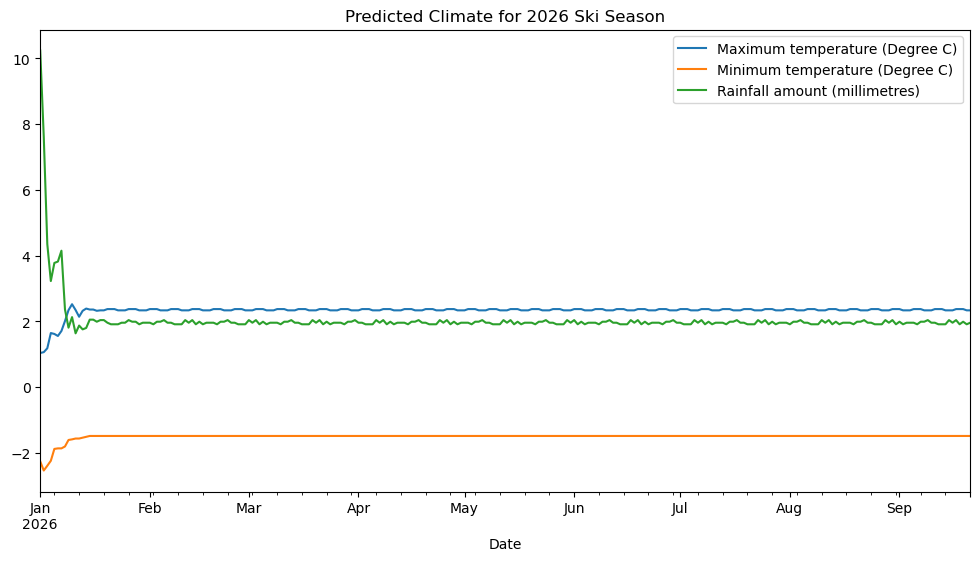

In [237]:
future_preds_df[['Maximum temperature (Degree C)', 
                 'Minimum temperature (Degree C)', 
                 'Rainfall amount (millimetres)']].plot(figsize=(12,6))
plt.title("Predicted Climate for 2026 Ski Season")
plt.show()